<a href="https://colab.research.google.com/github/KuanChihLee/Supervised-Learning/blob/master/Assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This assignment implements Neural Network to classificaiton problem.


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import numpy as np
import pandas as pd
import math

csv_file = "./HW5_dataset.csv"
data = pd.read_csv(csv_file)
data = data.rename(index=str, columns={"a": "x1", "b": "x2", "label":"y"});

In [0]:
data.head(5)

,x1,x2,y
0,7.308150,3.378029,1
1,-16.243747,-16.011393,0
2,7.584490,2.642162,1
3,-15.965623,-12.119112,0
4,-18.601721,15.422406,1


In [0]:
Train = data.sample(frac=0.70, random_state=20)
Test = data.drop(Train.index)
Valid = Test.sample(frac=0.6666, random_state=20)
Test = Test.drop(Valid.index)

print("Train size:", Train.shape)
print("Valid size:", Valid.shape)
print("Test size:", Test.shape)

Train size: (3500, 3)
Valid size: (1000, 3)
Test size: (500, 3)


#### NN Design: How many units in input layer and output layer? question(a)
Here, I use 2 predictors/units in input layer. And, output layer is 2 units corresponding to classes (0 and 1).
Ouput layer is transformed by softmax (activation function used in the last layer only), and loss function is cross-entropy.

#### Implementation sigmoid, hyperbolic tangent and rectifier linear activation- question(b)

In [0]:
def Sigmoid(X, derivative=False):
    sigm = 1. / (1. + np.exp(-X))
    if derivative:
        return sigm * (1. - sigm)
    return sigm

def ReLu(X, derivative=False):
    relu = X * (X > 0)
    if derivative:
        return 1. * (X > 0)
    return relu

def Tanh(X, derivative=False):
    tanh = np.tanh(X) 
    if derivative:
        return 1 - np.power(tanh, 2)
    return tanh

def Activation(X, function, derivative=False):
    if function == "relu":
        return ReLu(X, derivative)
    elif function == "tanh":
        return Tanh(X, derivative)
    else:
        return Sigmoid(X, derivative)

def calculate_loss(model, X, y, function, lamda, regul): 
    
    W0, B0, W1, B1 = model['W0'], model['B0'], model['W1'], model['B1'] 
    
    # Forward propagation to calculate our predictions 
    Z1 = X.dot(W0) + B0        # N x hidden_dim
    A1 = Activation(Z1, function)
    Z2 = A1.dot(W1) + B1       # N x output_dim
    indi_exp = np.exp(Z2)
    softmax_prob = indi_exp / np.sum(indi_exp, axis=1, keepdims=True)
    
    # Calculating the loss 
    correct_logprobs = -np.log(softmax_prob[range(X.shape[0]), y]) 
    data_loss = np.sum(correct_logprobs)
    
    # Add regulatization term to loss (optional)
    if regul == 'l2':
        data_loss += lamda/2 * (np.sum(np.square(W0)) + np.sum(np.square(W1)))
    elif regul == 'l1':
        data_loss += lamda * (np.sum(abs(W0)) + np.sum(abs(W1)))
    else:
        data_loss = data_loss
        
    return 1./X.shape[0] * data_loss     
    
def NN_Model(data, hidden_dim, output_dim, function="sigmoid", batch_size=100, epochs=10,
             lamda=0, regul=None, lr=0.1, print_loss=False):
    
    data_size, data_dims = data.shape
    update_times = math.ceil(data_size / batch_size)
    if batch_size >= data_size:
        sample_size = data_size
    else:
        sample_size = batch_size
    
    # Init W, Bias
    np.random.seed(0)
    W0 = np.random.randn(data_dims-1, hidden_dim)
    B0 = np.zeros((1, hidden_dim))
    W1 = np.random.randn(hidden_dim, output_dim)
    B1 = np.zeros((1, output_dim))
    
    # Return model (parameters)
    model = {}
    print("Function: ", function)
    for epo in range(epochs):
        for times in range(update_times):

            sub_data = data.sample(sample_size)
            X = sub_data.drop(sub_data.columns[-1], axis=1).values
            y = sub_data[sub_data.columns[-1]].values
           
            # Forward Pass
            Z1 = X.dot(W0) + B0        # N x hidden_dim
            A1 = Activation(Z1, function)
            Z2 = A1.dot(W1) + B1       # N x output_dim
            indi_exp = np.exp(Z2)
            softmax_prob = indi_exp / np.sum(indi_exp, axis=1, keepdims=True)

            #Backward Pass
            dZ2 = softmax_prob 
            dZ2[range(sample_size), y] -= 1
            dW1 = (A1.T).dot(dZ2)
            dB1 = np.sum(dZ2, axis=0)
            dZ1 = dZ2.dot(W1.T) * Activation(Z1, function, derivative=True)
            dW0 = (X.T).dot(dZ1)
            dB0 = np.sum(dZ1, axis=0)

            if regul == 'l2':
                W1 = (1 - lr*lamda) * W1 - lr * dW1
                W0 = (1 - lr*lamda) * W0 - lr * dW0
            elif regul == 'l1':
                W1 = W1 - lr * dW1 - lr * lamda * np.sign(W1)
                W0 = W0 - lr * dW0 - lr * lamda * np.sign(W0)
            else:
                W1 -= lr * dW1 
                W0 -= lr * dW0
            B1 -= lr * B1
            B0 -= lr * B0

            model = {'W0': W0, 'B0': B0, 'W1': W1, 'B1': B1}
            #if times%1000 == 0:
            #    print(times, " times for batch")

        if print_loss and (epo+1)%100 == 0: 
            print("Loss after iteration %i: %f" %
                  (epo+1, calculate_loss(model, X, y, function, lamda, regul))) 
        
    return model

In [0]:
def predict(model, data, function="sigmoid"): 
    
    W0, B0, W1, B1 = model['W0'], model['B0'], model['W1'], model['B1'] 
    X = data.drop(data.columns[-1], axis=1).values
    
    # Forward propagation 
    Z1 = X.dot(W0) + B0        # N x hidden_dim
    A1 = Activation(Z1, function)
    Z2 = A1.dot(W1) + B1       # N x output_dim
    indi_exp = np.exp(Z2) 
    softmax_prob = indi_exp / np.sum(indi_exp, axis=1, keepdims=True) 
    return np.argmax(softmax_prob, axis=1) 
    
def plot_decision_boundary(data, predicton_function): 

    X = data.drop(data.columns[-1], axis=1)
    y = data[data.columns[-1]]
    
    # Set min and max values and give it some padding 
    x_min, x_max = X.iloc[:, 0].min() - .5, X.iloc[:, 0].max() + .5 
    y_min, y_max = X.iloc[:, 1].min() - 1.5, X.iloc[:, 1].max() + 1.5 
    h = 0.01
    
    # Generate a grid of points with distance h between them 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h)) 
    
    # Predict the function value for the whole gid
    obs = pd.DataFrame(np.c_[xx.ravel(), yy.ravel(), xx.ravel()], columns=['x1', 'x2', 'fake'])
    Z = predicton_function(obs) 
    Z = Z.reshape(xx.shape) 
    
    classes = [0, 1]
    markers = ['s', '.']
    colors = ['red', 'blue']
    
    # Plot the contour and training examples
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.contourf(xx, yy, Z, cmap='RdGy', alpha=0.3) 
    for color, mark, clas in zip(colors, markers, classes):
        x1 = [X.iloc[i,0] for i in range(X.shape[0]) if y[i] == clas]
        x2 = [X.iloc[i,1] for i in range(X.shape[0]) if y[i] == clas]
        ax.scatter(x1, x2, c=color, marker=mark, label="Class"+str(clas))
    ax.legend()
    ax.grid(False)

#### Following 3 cells implement different activation functions with L1 regularization.
batch_size=500, epoch=1000 and learning rate is 0.001 (ReLu learning rate is 0.0001). Weights and biases in each layer are marked as the dictionary names, 'W0', 'B0', 'W1', 'B1', in model (for example model['W0']).

In [0]:
# Hidden layer with tanh
model = NN_Model(data, hidden_dim=2, output_dim=2, function="tanh", batch_size=500, epochs=1000,
             lamda=1.0, regul='l2', lr=0.001, print_loss=True)

prediction = predict(model, Train, function="tanh")
error_num = sum(abs(prediction - Train[Train.columns[-1]].values))
print("Train Error Rate:", error_num / Train.shape[0] * 100, "%")

prediction = predict(model, Valid, function="tanh")
error_num = sum(abs(prediction - Valid[Valid.columns[-1]].values))
print("Valid Error Rate:", error_num / Valid.shape[0] * 100, "%")

Function:  tanh
Loss after iteration 100: 0.488286
Loss after iteration 200: 0.485181
Loss after iteration 300: 0.479538
Loss after iteration 400: 0.481746
Loss after iteration 500: 0.481439
Loss after iteration 600: 0.474314
Loss after iteration 700: 0.501996
Loss after iteration 800: 0.459661
Loss after iteration 900: 0.498177
Loss after iteration 1000: 0.501077
Train Error Rate: 24.628571428571426 %
Valid Error Rate: 24.4 %


In [0]:
# ReLu is really easier to encounter NaN value because W0 and W0 might be too big
# decease learning rate by a factor of 10
model = NN_Model(data, hidden_dim=2, output_dim=2, function="relu", batch_size=500, epochs=1000,
             lamda=1.0, regul='l2', lr=0.0001, print_loss=True)

prediction = predict(model, Train, function="relu")
error_num = sum(abs(prediction - Train[Train.columns[-1]].values))
print("Train Error Rate:", error_num / Train.shape[0] * 100, "%")

prediction = predict(model, Valid, function="relu")
error_num = sum(abs(prediction - Valid[Valid.columns[-1]].values))
print("Valid Error Rate:", error_num / Valid.shape[0] * 100, "%")

Function:  relu
Loss after iteration 100: 0.361464
Loss after iteration 200: 0.356502
Loss after iteration 300: 0.358559
Loss after iteration 400: 0.349609
Loss after iteration 500: 0.363231
Loss after iteration 600: 0.378768
Loss after iteration 700: 0.344064
Loss after iteration 800: 0.360862
Loss after iteration 900: 0.346801
Loss after iteration 1000: 0.356561
Train Error Rate: 25.4 %
Valid Error Rate: 24.9 %


In [0]:
# Hidden layer with sigmoid
model = NN_Model(data, hidden_dim=2, output_dim=2, function="sigmoid", batch_size=500, epochs=1000,
             lamda=1.0, regul='l2', lr=0.001, print_loss=True)

prediction = predict(model, Train, function="sigmoid")
error_num = sum(abs(prediction - Train[Train.columns[-1]].values))
print("Train Error Rate:", error_num / Train.shape[0] * 100, "%")

prediction = predict(model, Valid, function="sigmoid")
error_num = sum(abs(prediction - Valid[Valid.columns[-1]].values))
print("Valid Error Rate:", error_num / Valid.shape[0] * 100, "%")

Function:  sigmoid
Loss after iteration 100: 0.556285
Loss after iteration 200: 0.545484
Loss after iteration 300: 0.551131
Loss after iteration 400: 0.551198
Loss after iteration 500: 0.536943
Loss after iteration 600: 0.534630
Loss after iteration 700: 0.564721
Loss after iteration 800: 0.530854
Loss after iteration 900: 0.540561
Loss after iteration 1000: 0.545443
Train Error Rate: 50.828571428571436 %
Valid Error Rate: 52.2 %


#### Following one cell use ReLu as activation function and implement regularization with different λ.

In [0]:
lamda_list = [0.0, 0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2, 5, 8, 10, 20, 50, 100] 

best_lambda = 0
best_valid_error = 1
for lamda in lamda_list: 
    print("Lambda is ", lamda)
    model = NN_Model(data, hidden_dim=2, output_dim=2, function="relu", batch_size=500, 
                     epochs=1000, lamda=lamda, regul='l2', lr=0.0001, print_loss=False)
    
    prediction = predict(model, Train, function="relu")
    error_num = sum(abs(prediction - Train[Train.columns[-1]].values))
    print("Train Error Rate:", error_num / Train.shape[0] * 100, "%")

    prediction = predict(model, Valid, function="relu")
    error_num = sum(abs(prediction - Valid[Valid.columns[-1]].values))
    print("Valid Error Rate:", error_num / Valid.shape[0] * 100, "%")
    if (error_num/Valid.shape[0]) < best_valid_error:
        best_valid_error = error_num/Valid.shape[0]
        best_lambda = lamda

Lambda is  0.0
Function:  relu
Train Error Rate: 25.4 %
Valid Error Rate: 24.9 %
Lambda is  0.01
Function:  relu
Train Error Rate: 25.4 %
Valid Error Rate: 24.9 %
Lambda is  0.05
Function:  relu
Train Error Rate: 25.4 %
Valid Error Rate: 24.9 %
Lambda is  0.1
Function:  relu
Train Error Rate: 25.4 %
Valid Error Rate: 24.9 %
Lambda is  0.5
Function:  relu
Train Error Rate: 25.4 %
Valid Error Rate: 24.9 %
Lambda is  1.0
Function:  relu
Train Error Rate: 25.4 %
Valid Error Rate: 24.9 %
Lambda is  1.5
Function:  relu
Train Error Rate: 25.4 %
Valid Error Rate: 24.9 %
Lambda is  2
Function:  relu
Train Error Rate: 25.4 %
Valid Error Rate: 24.9 %
Lambda is  5
Function:  relu
Train Error Rate: 25.4 %
Valid Error Rate: 24.9 %
Lambda is  8
Function:  relu
Train Error Rate: 25.4 %
Valid Error Rate: 24.9 %
Lambda is  10
Function:  relu
Train Error Rate: 25.4 %
Valid Error Rate: 24.9 %
Lambda is  20
Function:  relu
Train Error Rate: 25.4 %
Valid Error Rate: 24.9 %
Lambda is  50
Function:  relu
Trai

#### Find the best lambda in validation set and try it on Test data set.

In [0]:
print("Best Lambda: ", best_lambda)

model = NN_Model(data, hidden_dim=2, output_dim=2, function="relu", batch_size=500, 
                 epochs=1000, lamda=best_lambda, regul='l2', lr=0.0001, print_loss=False)

prediction = predict(model, Train, function="relu")
error_num = sum(abs(prediction - Train[Train.columns[-1]].values))
print("Train Error Rate:", error_num / Train.shape[0] * 100, "%")

prediction = predict(model, Test, function="relu")
error_num = sum(abs(prediction - Test[Test.columns[-1]].values))
print("Test Error Rate:", error_num / Test.shape[0] * 100, "%")

Best Lambda:  0.0
Function:  relu
Train Error Rate: 25.4 %
Test Error Rate: 22.400000000000002 %


#### Repeat above processes with 10-units hidden layer- question(c)

In [0]:
lamda_list = [0.0, 0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2, 5, 8, 10, 20, 50, 100] 

best_lambda = 0
best_valid_error = 1
for lamda in lamda_list: 
    print("Lambda is ", lamda)
    model = NN_Model(data, hidden_dim=10, output_dim=2, function="relu", batch_size=500, 
                     epochs=1000, lamda=lamda, regul='l2', lr=0.0001, print_loss=False)
    
    prediction = predict(model, Train, function="relu")
    error_num = sum(abs(prediction - Train[Train.columns[-1]].values))
    print("Train Error Rate:", error_num / Train.shape[0] * 100, "%")

    prediction = predict(model, Valid, function="relu")
    error_num = sum(abs(prediction - Valid[Valid.columns[-1]].values))
    print("Valid Error Rate:", error_num / Valid.shape[0] * 100, "%")
    if (error_num/Valid.shape[0]) < best_valid_error:
        best_valid_error = error_num/Valid.shape[0]
        best_lambda = lamda

Lambda is  0.0
Function:  relu
Train Error Rate: 0.0 %
Valid Error Rate: 0.0 %
Lambda is  0.01
Function:  relu
Train Error Rate: 0.0 %
Valid Error Rate: 0.0 %
Lambda is  0.05
Function:  relu
Train Error Rate: 0.0 %
Valid Error Rate: 0.0 %
Lambda is  0.1
Function:  relu
Train Error Rate: 0.0 %
Valid Error Rate: 0.0 %
Lambda is  0.5
Function:  relu
Train Error Rate: 0.0 %
Valid Error Rate: 0.0 %
Lambda is  1.0
Function:  relu
Train Error Rate: 0.0 %
Valid Error Rate: 0.0 %
Lambda is  1.5
Function:  relu
Train Error Rate: 0.0 %
Valid Error Rate: 0.0 %
Lambda is  2
Function:  relu
Train Error Rate: 0.0 %
Valid Error Rate: 0.0 %
Lambda is  5
Function:  relu
Train Error Rate: 0.0 %
Valid Error Rate: 0.0 %
Lambda is  8
Function:  relu
Train Error Rate: 0.0 %
Valid Error Rate: 0.0 %
Lambda is  10
Function:  relu
Train Error Rate: 0.0 %
Valid Error Rate: 0.0 %
Lambda is  20
Function:  relu
Train Error Rate: 0.0 %
Valid Error Rate: 0.0 %
Lambda is  50
Function:  relu
Train Error Rate: 0.0 %
Vali

#### Find the best lambda in validation set and try it on Test data set.

In [0]:
print("Best Lambda: ", best_lambda)

model = NN_Model(data, hidden_dim=10, output_dim=2, function="relu", batch_size=500, 
                 epochs=1000, lamda=best_lambda, regul='l2', lr=0.0001, print_loss=False)

prediction = predict(model, Train, function="relu")
error_num = sum(abs(prediction - Train[Train.columns[-1]].values))
print("Train Error Rate:", error_num / Train.shape[0] * 100, "%")

prediction = predict(model, Test, function="relu")
error_num = sum(abs(prediction - Test[Test.columns[-1]].values))
print("Test Error Rate:", error_num / Test.shape[0] * 100, "%")

Best Lambda:  0.0
Function:  relu
Train Error Rate: 0.0 %
Test Error Rate: 0.2 %


#### Decision Boundary- question(d)

In [0]:
print("Best Lambda: ", 0.0)
model = NN_Model(data, hidden_dim=2, output_dim=2, function="relu", batch_size=500, 
                 epochs=1000, lamda=0.0, regul='l2', lr=0.0001, print_loss=False)

prediction = predict(model, Train, function="relu")
error_num = sum(abs(prediction - Train[Train.columns[-1]].values))
print("Train Error Rate:", error_num / Train.shape[0] * 100, "%")

Best Lambda:  0.0
Function:  relu
Train Error Rate: 25.4 %


Text(0.5, 1.0, 'Decision Boundary for 2-Units Hidden Layer')

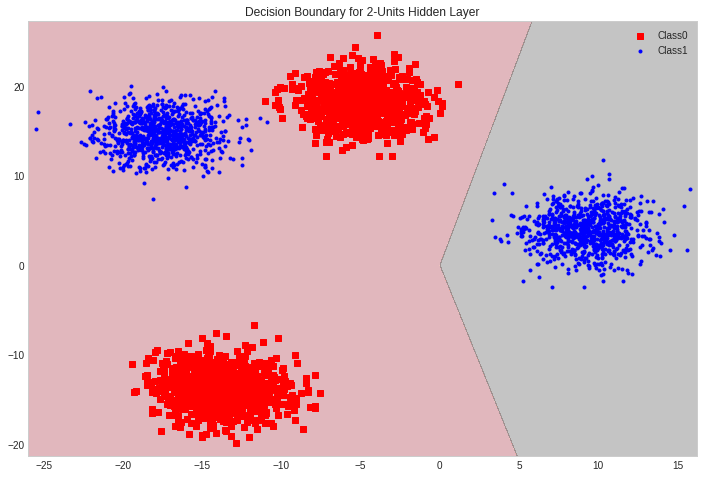

In [0]:
# Plot the decision boundary 
plot_decision_boundary(Train, lambda x: predict(model, x, function="relu")) 
plt.title("Decision Boundary for 2-Units Hidden Layer") 

In [0]:
print("Best Lambda: ", 0.0)
model = NN_Model(data, hidden_dim=10, output_dim=2, function="relu", batch_size=500, 
                 epochs=1000, lamda=0.0, regul='l2', lr=0.0001, print_loss=False)

prediction = predict(model, Train, function="relu")
error_num = sum(abs(prediction - Train[Train.columns[-1]].values))
print("Train Error Rate:", error_num / Train.shape[0] * 100, "%")

Best Lambda:  0.0
Function:  relu
Train Error Rate: 0.0 %


Text(0.5, 1.0, 'Decision Boundary for 10-Units Hidden Layer')

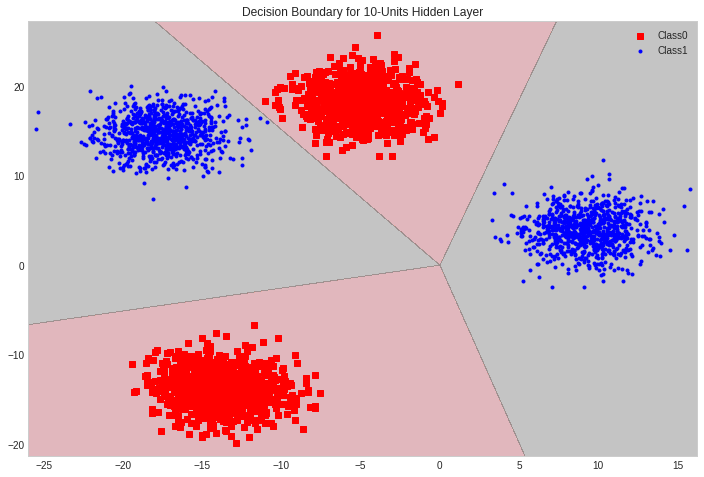

In [0]:
# Plot the decision boundary 
plot_decision_boundary(Train, lambda x: predict(model, x, function="relu")) 
plt.title("Decision Boundary for 10-Units Hidden Layer") 

#### Explanation:
It's obvious that the dicision boundary in 10-units Hidden layer NN is more complicated than 2-units one. Therefore, 10-units NN can successfully separate four groups of data marked as different labels in predictor domain, X1 vs. X2. Also, because I use ReLu as activation function in hidden layer, boundaries are linear in each section.